Data source: https://dataunderground.org/dataset/landmass-f3
- Credits to researchers at Georgia Tech, Agile Geoscience
- License CCbySA

In [4]:
import h5py
from tqdm.auto import tqdm
from pathlib import Path
import torch
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/wassname/.pyenv/versions/jup3.7.3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# View

In [5]:
data_in = Path("../../data/raw/landmass-f3/")
data_out = Path("../../data/processed/landmass-f3/")

In [6]:
with h5py.File(data_in / "Landmass_CC-BY-SA.h5", "r") as f:
    print(list(f.attrs))
    print(list(f))
    for k in ["LANDMASS-1", "LANDMASS-2"]:
        print(k, list(f[k]))

['README', 'licence', 'location', 'owner', 'reference', 'survey', 'uri', 'version']
['LANDMASS-1', 'LANDMASS-2']
LANDMASS-1 ['Chaotic Horizon', 'Fault', 'Horizon', 'Salt Dome']
LANDMASS-2 ['Chaotic Horizon', 'Fault', 'Horizon', 'Salt Dome']


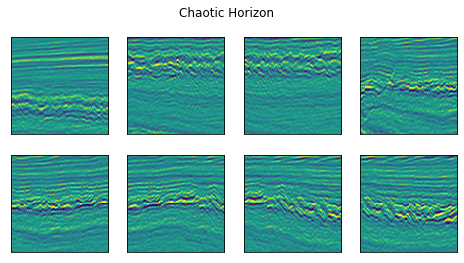

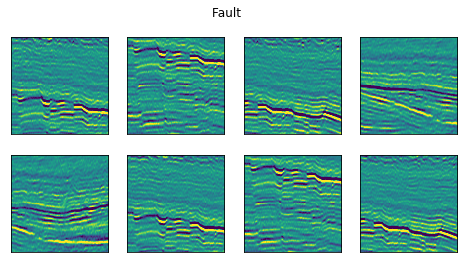

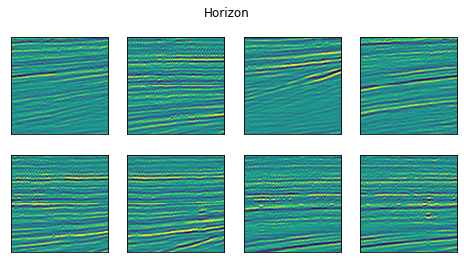

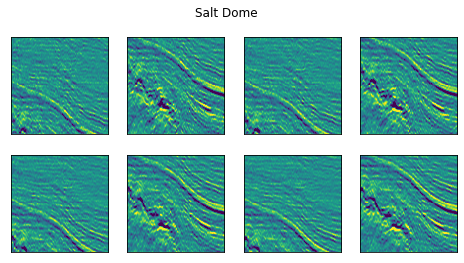

In [4]:
f = h5py.File(data_in / "Landmass_CC-BY-SA.h5", "r")
nrows = 2
ncols = 4
for key in f["LANDMASS-1"].keys():
    d = f["LANDMASS-1"][key][: nrows * ncols, :, :, 0]

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 4))

    for i in range(ncols * nrows):

        ax = axs[i // ncols][i % ncols]
        ax.imshow(d[i])
        ax.set_xticks([])
        ax.set_yticks([])

    #     plt.tight_layout()
    plt.suptitle(f"{key}")
    plt.show()

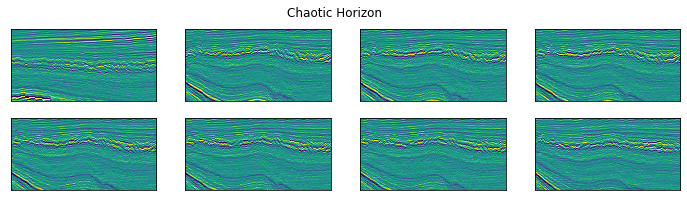

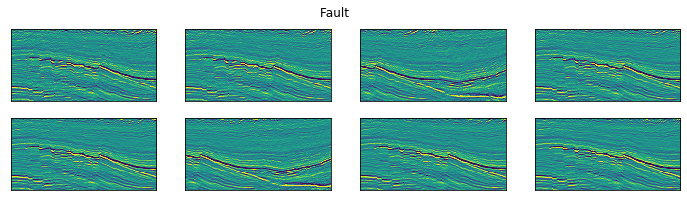

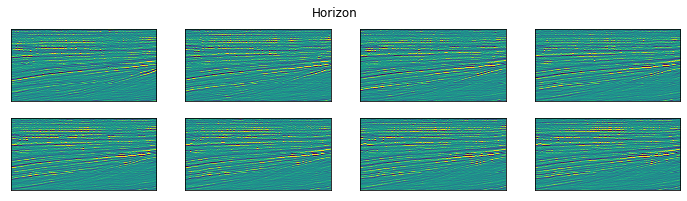

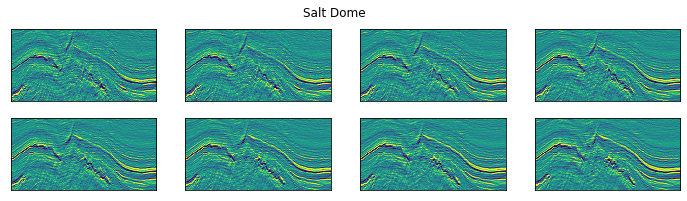

In [72]:
f = h5py.File(data_in / "Landmass_CC-BY-SA.h5", "r")
nrows = 2
ncols = 4
for key in f["LANDMASS-2"].keys():
    d = f["LANDMASS-2"][key][: nrows * ncols, :, :, 0]

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 3))

    for i in range(ncols * nrows):

        ax = axs[i // ncols][i % ncols]
        ax.imshow(d[i])
        ax.set_xticks([])
        ax.set_yticks([])

    #     plt.tight_layout()
    plt.suptitle(f"{key}")
    plt.show()

# Split

In [7]:
from sklearn.model_selection import train_test_split
import torch

In [25]:
f = h5py.File(data_in / "Landmass_CC-BY-SA.h5", "r")
classes = ["Chaotic Horizon", "Fault", "Horizon", "Salt Dome"]
X = []
Y = []
for i, key in enumerate(tqdm(classes)):
    x = np.array(f["LANDMASS-1"][key].value)

    # convert to uint8
    x = (x + 1) / 2
    x *= 255
    x = x.astype(np.uint8)

    y = np.ones(x.shape[0]) * i
    X.append(x)
    Y.append(y)
    print(i, key, x.shape, x.min(), x.max())

X = np.concatenate(X, 0).astype(np.uint8)
Y = np.concatenate(Y, 0).astype(np.uint8)
X.shape, Y.shape



  0%|          | 0/4 [00:00<?, ?it/s]/home/wassname/.pyenv/versions/jup3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:6: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  


 25%|██▌       | 1/4 [00:03<00:09,  3.05s/it]

0 Chaotic Horizon (5140, 99, 99, 1) 0 255




 50%|█████     | 2/4 [00:03<00:04,  2.35s/it]

1 Fault (1251, 99, 99, 1) 0 255




 75%|███████▌  | 3/4 [00:09<00:03,  3.25s/it]

2 Horizon (9385, 99, 99, 1) 0 255




100%|██████████| 4/4 [00:10<00:00,  2.54s/it]

3 Salt Dome (1891, 99, 99, 1) 0 255


((17667, 99, 99, 1), (17667,))

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42)

with (data_out / "LandmassF3Patches/processed/training.pt").open("wb") as fo:
    torch.save((torch.from_numpy(X_train)[:, :, :, 0], torch.from_numpy(y_train)), fo)
    print(fo)

with (data_out / "LandmassF3Patches/processed/test.pt").open("wb") as fo:
    torch.save((torch.from_numpy(X_test)[:, :, :, 0], torch.from_numpy(y_test)), fo)
    print(fo)

<_io.BufferedWriter name='../../data/processed/landmass-f3/LandmassF3Patches/processed/training.pt'>
<_io.BufferedWriter name='../../data/processed/landmass-f3/LandmassF3Patches/processed/test.pt'>


In [39]:
np.split(X_train, 26)

ValueError: array split does not result in an equal division

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42)
X_train = np.concatenate(
    [
        X_train[:, :26, :26, 0],
        X_train[:, 26 * 1 : 26 * 2, 26 * 1 : 26 * 2, 0],
        X_train[:, 26 * 2 : 26 * 3, 26 * 2 : 26 * 3, 0],
    ]
)
y_train = np.concatenate([y_train, y_train, y_train])
y_test = np.concatenate([y_test, y_test, y_test])
X_test = np.concatenate(
    [
        X_test[:, :26, :26, 0],
        X_test[:, 26 * 1 : 26 * 2, 26 * 1 : 26 * 2, 0],
        X_test[:, 26 * 2 : 26 * 3, 26 * 2 : 26 * 3, 0],
    ]
)
print(X_train.shape, y_train.shape)
with (data_out / "LandmassF3PatchesMini/processed/training.pt").open("wb") as fo:
    torch.save((torch.from_numpy(X_train), torch.from_numpy(y_train)), fo)
    print(fo)

with (data_out / "LandmassF3PatchesMini/processed/test.pt").open("wb") as fo:
    torch.save((torch.from_numpy(X_test), torch.from_numpy(y_test)), fo)
    print(fo)

(39750, 26, 26) (39750,)
<_io.BufferedWriter name='../../data/processed/landmass-f3/LandmassF3PatchesMini/processed/training.pt'>
<_io.BufferedWriter name='../../data/processed/landmass-f3/LandmassF3PatchesMini/processed/test.pt'>


In [67]:
torch.load(data_out / "LandmassF3PatchesMini/processed/training.pt")[0].shape

torch.Size([39750, 26, 26])

# Load

In [8]:
from torchvision.datasets import MNIST

mnist = MNIST("/tmp/mnist", download=True)
x, y = mnist[5]
np.array(x).shape

(28, 28)

Dataset LandmassF3Patches
    Number of datapoints: 13250
    Root location: /media/wassname/Storage5/projects2/3ST/deep_ml_curriculum_private/data/processed/landmass-f3
    Split: Train
Chaotic Horizon
(99, 99)


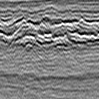

In [9]:
from deep_ml_curriculum.data.landmass_f3 import LandmassF3Patches, LandmassF3PatchesMini
from deep_ml_curriculum.config import project_dir


landmassf3 = LandmassF3Patches(project_dir / "data/processed/landmass-f3")
print(landmassf3)
x, y = landmassf3[4]
print(landmassf3.classes[y])
print(np.array(x).shape)
x

In [10]:
# WARNING This may be too small to see patterns, which may lower accuracy a lot on an already hard task
landmassf3mini = LandmassF3PatchesMini(project_dir / "data/processed/landmass-f3")
print(landmassf3mini)
x, y = landmassf3mini[40]
print(landmassf3.classes[y])
print(np.array(x).shape)
x

Dataset LandmassF3PatchesMini
    Number of datapoints: 39750
    Root location: /media/wassname/Storage5/projects2/3ST/deep_ml_curriculum_private/data/processed/landmass-f3
    Split: Train
Horizon
(26, 26)
